In [13]:
import gym
import torch
import random
import torch.nn as nn
import collections
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal

In [14]:
class ReplayBeffer():
    def __init__(self, buffer_maxlen):
        self.buffer = collections.deque(maxlen = buffer_maxlen)
    
    def push(self, data):
        self.buffer.append(data)
    
    def sample(self, batch_size):
        state_list = []
        action_list = []
        reward_list = []
        next_state_list = []
        done_list = []
        
        batch = random.sample(self.buffer, batch_size)
        for experience in batch:
            s, a, r, n_s, d = experience
            #state, action, reward, next_state, done
            
            state_list.append(s)
            action_list.append(a)
            reward_list.append(r)
            next_state_list.append(n_s)
            done_list.append(d)
            
        return torch.FloatTensor(state_list).to(device),\
               torch.FloatTensor(action_list).to(device),\
               torch.FloatTensor(reward_list).unsqueeze(-1).to(device),\
               torch.FloatTensor(next_state_list).to(device),\
               torch.FloatTensor(done_list).unsqueeze(-1).to(device)
        
    def buffer_len(self):
        return len(self.buffer)

In [15]:
# Value Net
class ValueNet(nn.Module):
    def __init__(self, state_dim, edge=3e-3):
        super(ValueNet, self).__init__()
        self.linear1 = nn.Linear(state_dim, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 1)
        
        self.linear3.weight.data.uniform_(-edge, edge)
        self.linear3.bias.data.uniform_(-edge, edge)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

# Soft Q Net
class SoftQNet(nn.Module):
    def __init__(self, state_dim, action_dim, edge=3e-3):
        super(SoftQNet, self).__init__()
        self.linear1 = nn.Linear(state_dim + action_dim, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 1)
        
        self.linear3.weight.data.uniform_(-edge, edge)
        self.linear3.bias.data.uniform_(-edge, edge)
        
    def forward(self, state, action):
        x = torch.cat([state,action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
    
        return x

# Policy Net
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim, log_std_min = -20, log_std_max=2, edge=3e-3):
        super(PolicyNet, self).__init__()
        self.log_std_min = log_std_min 
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(state_dim, 256)
        self.linear2 = nn.Linear(256, 256)
        
        self.mean_linear = nn.Linear(256, action_dim)
        self.mean_linear.weight.data.uniform_(-edge, edge)
        self.mean_linear.bias.data.uniform_(-edge, edge)
        
        self.log_std_linear = nn.Linear(256, action_dim)
        self.log_std_linear.weight.data.uniform_(-edge, edge)
        self.log_std_linear.bias.data.uniform_(-edge, edge)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std

    def action(self, state):
        state = torch.FloatTensor(state).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        
        z = normal.sample()
        action = torch.tanh(z).detach().cpu().numpy()
            
        return action
    
    # Use re-parameterization tick
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        noise = Normal(0,1)
        
        z = noise.sample()
        action = torch.tanh(mean + std*z.to(device))
        log_prob = normal.log_prob(mean + std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        
        return action, log_prob

In [16]:
class SAC:
    def __init__(self, env, gamma, tau, buffer_maxlen, value_lr, q_lr, policy_lr):
        
        self.env = env
        self.state_dim  = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_range = [env.action_space.low, env.action_space.high]
        
        # hyperparameters
        self.gamma = gamma
        self.tau = tau
        
        # initialize networks 
        self.value_net = ValueNet(self.state_dim).to(device)
        self.target_value_net = ValueNet(self.state_dim).to(device)
        self.q1_net = SoftQNet(self.state_dim, self.action_dim).to(device)
        self.q2_net = SoftQNet(self.state_dim, self.action_dim).to(device)
        self.policy_net = PolicyNet(self.state_dim, self.action_dim).to(device)
        
        # Load the target value network parameters
        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(self.tau * param + (1 - self.tau) * target_param) 
        
        # Initialize the optimizer
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=value_lr)
        self.q1_optimizer = optim.Adam(self.q1_net.parameters(), lr=q_lr)
        self.q2_optimizer = optim.Adam(self.q2_net.parameters(), lr=q_lr)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=policy_lr)
        
        # Initialize thebuffer
        self.buffer = ReplayBeffer(buffer_maxlen)
        
    def get_action(self, state):
        action = self.policy_net.action(state)
        action = action* (self.action_range[1] - self.action_range[0]) / 2.0 +\
                         (self.action_range[1] + self.action_range[0]) / 2.0
        
        return action

        
    def update(self, batch_size):
        state, action, reward, next_state, done = self.buffer.sample(batch_size)
        new_action, log_prob = self.policy_net.evaluate(state)
        
        # V value loss
        value = self.value_net(state)
        new_q1_value = self.q1_net(state, new_action)
        new_q2_value = self.q2_net(state, new_action)
        next_value = torch.min(new_q1_value, new_q2_value) - log_prob
        value_loss = F.mse_loss(value, next_value.detach())
        
        # Soft q  loss
        q1_value = self.q1_net(state, action)
        q2_value = self.q2_net(state, action)
        target_value = self.target_value_net(next_state)
        target_q_value = reward + done*self.gamma*target_value
        q1_value_loss = F.mse_loss(q1_value, target_q_value.detach())
        q2_value_loss = F.mse_loss(q2_value, target_q_value.detach())
        
        # Policy loss
        policy_loss = (log_prob - torch.min(new_q1_value, new_q2_value)).mean()
        
        # Update v
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # Update Soft q
        self.q1_optimizer.zero_grad()
        self.q2_optimizer.zero_grad()
        q1_value_loss.backward()
        q2_value_loss.backward()
        self.q1_optimizer.step()
        self.q2_optimizer.step()
        
        # Update Policy
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        # Update target networks
        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(self.tau * param + (1 - self.tau) * target_param) 

In [17]:
def main(env, agent, Episode, batch_size):
    Return = []
    for episode in range(Episode):
        score = 0
        state = env.reset()
        for i in range(300):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            done_mask = 0.0 if done else 1.0
            agent.buffer.push((state, action, reward, next_state, done_mask))
            state = next_state
            
            score += reward
            if done:
                break
            if agent.buffer.buffer_len() > 500:
                agent.update(batch_size)
            
        print("episode:{}, Return:{}, buffer_capacity:{}".format(episode, score, agent.buffer.buffer_len()))
        Return.append(score)
        score = 0
    env.close()
    plt.plot(Return)
    plt.ylabel('Return')
    plt.xlabel("Episode")
    plt.grid(True)
    plt.show()

episode:0, Return:-1147.0184030409628, buffer_capacity:200
episode:1, Return:-963.20645112225, buffer_capacity:400
episode:2, Return:-863.3681198382313, buffer_capacity:600
episode:3, Return:-1066.016264412291, buffer_capacity:800
episode:4, Return:-1180.8898202970215, buffer_capacity:1000
episode:5, Return:-1603.2590620474318, buffer_capacity:1200
episode:6, Return:-1643.98081763648, buffer_capacity:1400
episode:7, Return:-1226.4071726952122, buffer_capacity:1600
episode:8, Return:-1649.861335823698, buffer_capacity:1800
episode:9, Return:-1432.798688252325, buffer_capacity:2000
episode:10, Return:-778.2931973494251, buffer_capacity:2200
episode:11, Return:-858.9097084609703, buffer_capacity:2400
episode:12, Return:-1272.0369632485017, buffer_capacity:2600
episode:13, Return:-1017.9643584612579, buffer_capacity:2800
episode:14, Return:-1186.2200323439192, buffer_capacity:3000
episode:15, Return:-926.4725527187028, buffer_capacity:3200
episode:16, Return:-127.83217369269514, buffer_cap

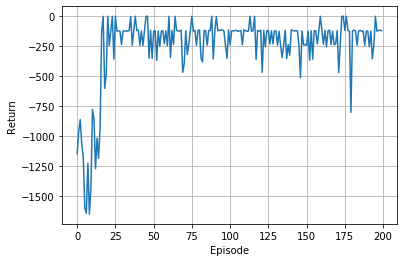

In [18]:
if __name__ == '__main__':
    env = gym.make("Pendulum-v0")
    device = torch.device("cuda:1"if torch.cuda.is_available() else "cpu")

    # Params
    tau = 0.01
    gamma = 0.99
    q_lr = 3e-3
    value_lr = 3e-3
    policy_lr = 3e-3
    buffer_maxlen = 50000
    
    Episode = 200
    batch_size = 128
    
    agent = SAC(env, gamma, tau, buffer_maxlen, value_lr, q_lr, policy_lr)
    main(env, agent, Episode, batch_size)